In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from re import findall
from hazm import Stemmer, word_tokenize
from sklearn.feature_selection import chi2, SelectKBest
from glob import glob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

"""Countvectorzer initialize"""
vect = CountVectorizer()
is_file = True

"""stemmer from hazm"""
stemmer = Stemmer()
stopwords = set(open('stop-words.txt', encoding='utf8').read().splitlines())
hamtrains = glob('dataset/hamtraining/hamtraining*.txt')
spamtrains = glob('dataset/spamtraining/spamtraining*.txt')

hamtests = glob('dataset/hamtesting/hamtesting*.txt')
spamtests = glob('dataset/spamtesting/spamtesting*.txt')

ham_spam_test = hamtests + spamtests
ham_spam_train = hamtrains + spamtrains

y_train = [False for i in range(300)]
y_spam_train = [True for i in range(300)]
y_train.extend(y_spam_train)


y_test = [False for i in range(200)]
y_spam_test = [True for i in range(200)]
y_test.extend(y_spam_test)

### Preprocess

In [2]:
class const:
    farsi = ('ب', 'س', 'ش', 'ل', 'ت', 'ن', 'م', 'گ', 'ظ', 'ط', 'ز',
             'ر', 'ژ', 'ذ', 'د', 'پ', 'چ', 'ج', 'ح', 'ع', 
             'خ', 'غ', 'ف', 'ق', 'ث', 'ص', 'ض','\u0020', '\u060c','؟', '!', '?', '.', ':','\n','_')

    alef = ('ا', 'آ', 'ء', 'أ', 'إ')
    vav = ('و', 'ؤ')
    heh = ('ه', 'ة', 'ە')
    yah = ('ی', 'ي', 'ئ', 'ى')
    kaf = ('ک', 'ك')
    punc = ('_', '-')

def persian_char(char):
    if char in const.farsi:
        return char
    if char in const.alef:
        return const.alef[0]
    if char in const.vav:
        return const.vav[0]
    if char in const.heh:
        return const.heh[0]
    if char in const.yah:
        return const.yah[0]
    if char in const.kaf:
        return const.kaf[0]
    if char in const.punc:
      return ' '
    return ''

def pre_process(path):
    if is_file == False:
        text = path
    else:
        text = open(path, encoding='utf8').read()

#     urls = len(findall('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', text))
    
    map_test = map(persian_char, text)
    sentence = ''.join(map_test)
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [w for w in word_tokens if w not in stopwords] #+ ['url' for i in range(urls)]
    filtered_sentence = ' '.join(filtered_sentence)
    return filtered_sentence

In [3]:
def feature(data):
    if is_file == False:
        feature_list = [pre_process(data)]
    else:    
        map_loop = map(pre_process, data)
        feature_list = list(map_loop)
    return feature_list

In [4]:
def vectorize(feature_list):
    X_dtm = vect.fit_transform(feature_list)
    X_dtm = X_dtm.toarray()
    return X_dtm

In [5]:
def feature_selection(k,X_dtm):
    chi2_features = SelectKBest(chi2, k=k)
    X_kbest_features = chi2_features.fit_transform(X_dtm, y_train)
    return X_kbest_features, chi2_features

In [6]:
def transform(data,chi2_features):
    tokens = feature(data)
    x0 = vect.transform(tokens).toarray()
    cx = chi2_features.transform(x0)
    return cx

In [22]:
X_dtm = vectorize(feature(ham_spam_train))
x_train, chi2_features = feature_selection(700,X_dtm)

### Just for Intuition

In [8]:
# gnb = GaussianNB()
mnb = MultinomialNB()
mnb.fit(x_train,y_train)

MultinomialNB()

In [40]:
"""Just for test and compare"""
x_test = transform(ham_spam_test, chi2_features)
predict_val = mnb.predict(x_test)
aaaa = x_train[range(5)]
bbbb = list(map(sum,zip(*aaaa)))
bbbb[6]

0

In [10]:
"""Show metrics and score!"""
print(classification_report(y_test, predict_val))

              precision    recall  f1-score   support

       False       0.93      0.97      0.95       200
        True       0.97      0.93      0.95       200

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



### Naive bayes model

<h2 dir="rtl"> ویدیو بسیار مفید برای ساخت مدل<h2>
<h2><a href="https://www.youtube.com/watch?v=O2L2Uv9pdDA">Naive Bayes, Clearly Explained!!!</a><h2>

<h3 dir="rtl">خرجی تابع
transform 
وکتورایز شده هر یک از سمپل‌های موجود در دیتاست تست است.
به طوری که تعداد اعضای 
test_data
برابر با 400 نمونه متنی است که برای تست کردن مدل مورد استفاده قرار میگیرد.
هر یک از سمپل‌ها دارای وکتوری به طول 700 میباشد، که تعداد فیچرهای(کلمات) برتر انتخاب شده توسط تابع SelectKBest 
اند.

در این وکتور 700 بعدی مقدار هر یک از اندیس‌ها نشان دهنده تکرار آن کلمه در آن سمپل خاص هست.

راهنمایی ساخت جدول احتمالات:
شما با کمک تکرار کلمات در هر سمپل و اینکه هر کلمه در کل نمونه‌های 
spam
یا
ham
چند بار تکرار شده است میتوانید احتمال رخدادن هر کلمه را در هر دسته بدست آورید
که در نهایت با ضرب احتمالات بدست آمده تعیین میکنید که ایمیل 
spam
است یا نه.

به این شکل که بعد از ضرب احتمالات در هم دیگر؛ اگر مقدار احتمال دسته 
spam 
بیشتر از دسته 
ham(nonspam)
بود،
آنگاه آن ایمیل spam 
است.
<h3>

In [43]:
test_data = transform(ham_spam_test, chi2_features)

In [44]:
test_data[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

<h3 dir="rtl"> 
شما باید با کمک این فیچر‌ها مدل 
naive bayes 
را برای تشخیص ایمیل‌های 
spam, nonspam
آماده سازی کنید.
خروجی کار شما باید لیبل‌های باشد که تعیین میکند،
ایمیل 
spam هست
یا نه.

<h3>

<h1>Please implement your naive bayse model in here.<h1>

In [49]:
### START CODE HERE ### 
#Build your naive bayes classifier!
#True -> spam
#False -> ham
ind = y_train.index(True)
email_ham_prob = ind/len(x_train)
email_spam_prob = 1 - email_ham_prob
ham_x_train = x_train[range(ind)]
ham_sums = list(map(sum, zip(*ham_x_train)))
ham_total = sum(ham_sums)
alpha = 1
smooth_ham_sums = [x+alpha for x in ham_sums]
smooth_ham_total = ham_total + 700 * alpha
ham_probabilities = [x/smooth_ham_total for x in smooth_ham_sums]

#print("ham_probabilities : "+str(ham_probabilities))

spam_x_train = x_train[range(ind,len(x_train))]
spam_sums = list(map(sum, zip(*spam_x_train)))
spam_total = sum(spam_sums)
smooth_spam_sums = [x+alpha for x in spam_sums]
smooth_spam_total = spam_total + 700 * alpha
spam_probabilities = [x/smooth_spam_total for x in smooth_spam_sums]
### END CODE HERE ###

In [58]:
### START CODE HERE ### 
# y_predict = YOUR_MODEL(test_data)
def My_model(test_data):
    y_pred = []
    for i in range(len(test_data)):
        t = test_data[i]
        hp = np.array(ham_probabilities)
        ham_p = np.prod(np.power(hp,t)) * email_ham_prob
        
        sp = np.array(spam_probabilities)
        spam_p = np.prod(np.power(sp,t)) * email_spam_prob
        if spam_p >= ham_p:
            y_pred.append(True) #spam
        else:
            y_pred.append(False) #ham
        
    return y_pred

y_predict = My_model(test_data)
#print("y_predict is : ",str(y_predict))
#set(y_test) - set(y_predict)
### END CODE HERE ###

### Result

In [59]:
"""Show metrics and score!"""
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       False       0.93      0.97      0.95       200
        True       0.97      0.93      0.95       200

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



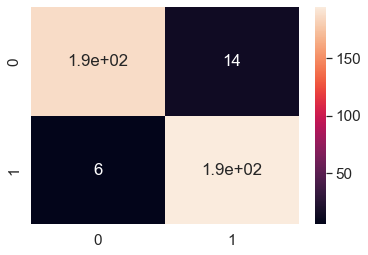

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_predict, labels=[True,False])
df_cm = pd.DataFrame(cm,range(2),range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm,annot=True) # font size
plt.show()

<h3 dir="rtl">
   در مواقعی که با 
    skewed classes
    سروکار داریم،
    accuracy
    معیار دقیقی برای سنجش عملکرد مدل به‌شمار نمی‌آید.
      برای مثال،در مسئله پیش بینی سرطان،درصورتیکه تنها 0.5درصد از مراجعان سرطان داشته باشند،
    کدی که همواره 
    y=0
    را پیش بینی کند نیز 
    accuracy
    بالایی خواهد داشت.
    برای حل این مشکل،می‌توان از معیار های 
    precision
    و
    recall
    استفاده کرد.
    
    
<h3>

<h3 dir="rtl">
   precision
    :
   چند درصد از افرادی که مدل پیش‌بینی کرده سرطان دارند،واقعا سرطان دارند؟ 
<h3>

<h3 dir="rtl">
   recall
    :
    از بین تمام مراجعینی که واقعا سرطان دارند،چند درصدشان توسط مدل ما شناسایی شده اند؟ 
<h3>

<h3 dir="rtl">
 مدلی که بدون یادگیری عمل کند و همواره 
    y=0
    یا
    y=1
    را پیش بینی کند،نمی‌تواند همزمان مقادیر 
    precision
    و
    recall
    خوبی داشته باشد.
    اگر هدف مان این باشد که تنها درصورتی به بیمار بگوییم سرطان دارد که درصد اطمینان بالایی داشته باشیم،
    دراینصورت مدلی با 
    precision
    بالا و به تبع آن،
    recall
    کمتر به هدف ما نزدیکتر خواهد بود.
    اما از طرفی مدل نباید تعداد زیادی از کیس های سرطانی را ازدست بدهد
    (اعلام کند که سرطان ندارند)
    برای رسیدن به هدف دوم،مدلی مناسبتر است که
    recall
    بالایی داشته باشد که بدین ترتیب،
    precision
    کاهش خواهد یافت.
    پس نیازمند برقراری تعادل میان مقادیر 
    precision
    و 
    recall 
    هستیم.
    
<h3>

<h3 dir="rtl">
   معیار ارزیابی
    F1 score
    این کار را برای ما انجام می‌دهد.
<h3>

$F_{1} score = 2 * \frac{P*R}{P+R}$

<h2 dir="rtl">
    گزارش کد
<h2>

<h3 dir="rtl">
    با توجه به اینکه در 
    y_train
    تمامی 
    True
    و
    False
    ها پشت سر هم هستند،با پیدا کردن اندیس اولین 
    True
    می‌توان 
    x_train
    را به دو دسته 
    ham_x_train
    و
    spam_x_train
    تقسیم کرد.
    
<h3>

<h3 dir="rtl">
   سپس تعداد کلمات کلیدی را در کل ایمیل های غیر اسپم و اسپم بدست می‌آوریم.
    با استفاده از 
    smoothing
    (آلفا را برابر با یک قرار دادیم)
    ،ham_probabilities
    و 
    spam_probabilities
    را بدست آوردیم
    (احتمال وجود هر یک از کلمات کلیدی در ایمیل های غیر اسپم و اسپم)
    سپس به ازای هر یک از اعضای 
    test_data
    با ضرب کردن احتمال وجود کلمات کلیدی موجود در این ایمیل در ایمیل های غیر اسپم و (اسپم) و ضرب این اعداد در 
       نسبت تعداد ایمیل های غیر اسپم (اسپم) به کل ایمیل ها،
    احتمال غیر اسپم یا اسپم بودن ایمیل را محاسبه کرده 
    و بر اساس اینکه کدام مقدار بیشتر است،
    پیشبینی غیر اسپم یا اسپم بودن ایمیل را انجام می‌دهیم.
<h3>